<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/TDG041821V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install --upgrade kmodes

In [20]:
from google.colab import drive
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

from plotnine import *
import plotnine

In [2]:
plot_kwds = {'alpha' : 0.5, 's' : 1, 'linewidths':0}

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Dataset de inventarios sin dimensiones de los productos
data3 = pd.read_csv("/content/gdrive/MyDrive/TDGdata/dfNoDims.csv")

In [5]:
data3

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR,CONTRPERC
0,17,IG56,HTS119,1/1,B,PC,CAT17,-289.8802,-2.63,0.01
1,17,IG56,HTS119,1/1,B,PC,CAT17,289.5527,25.00,0.00
2,17,IG56,HTS119,1/1,C,PC,CAT17,1111.3121,50.00,0.00
3,17,IG56,HTS119,1/1,B,PC,CAT17,-266.8633,-9.09,0.00
4,15,IG56,HTS119,1/1,C,PC,CAT17,-517.0436,-11.11,0.00
...,...,...,...,...,...,...,...,...,...,...
16239,23,IG5,HTS67,1/0,C,BX,CAT2,316.3834,1.00,0.00
16240,21,IG5,HTS67,1/0,C,BX,CAT2,626.9100,1.00,0.00
16241,22,IG5,HTS67,1/0,C,BX,CAT2,4959.6974,136.36,0.00
16242,24,IG5,HTS67,1/0,C,BX,CAT2,-1322.5860,-100.00,0.00


In [6]:
data3['CAT'] = data3['CAT'] + "-" + data3['ABC']

In [7]:
data3['AISLE']=data3['AISLE'].astype(str)

In [8]:
data3 =  data3.drop(['IG','HTS','PLANNING','ABC','UOM','CONTRPERC'], axis=1)

In [9]:
data3.sample(5)

,AISLE,CAT,COSTX,QTYVAR
3363,39,CAT7-C,-303.4643,-40.00
5686,4,CAT12-C,-5720.8096,-34.38
1170,12,CAT16-B,1870.2373,10.80
6456,16,CAT17-C,-379.4789,-100.00
9930,13,CAT17-B,-3.2316,-0.08


In [10]:
numdf = data3[list(data3.select_dtypes('float64').columns)]
scaled_features = StandardScaler().fit_transform(numdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=numdf.index, columns=numdf.columns)
scaled_features_df

,COSTX,QTYVAR
0,-0.029671,-0.037167
1,0.092655,-0.006905
2,0.266138,0.020477
3,-0.024812,-0.044242
4,-0.077628,-0.046455
...,...,...
16239,0.098319,-0.033191
16240,0.163875,-0.033191
16241,1.078580,0.115063
16242,-0.247688,-0.143812


In [11]:
catdf = data3[list(data3.select_dtypes('object').columns)]

In [12]:
data3 = pd.concat((catdf, scaled_features_df), axis = 1)
data3

,AISLE,CAT,COSTX,QTYVAR
0,17,CAT17-B,-0.029671,-0.037167
1,17,CAT17-B,0.092655,-0.006905
2,17,CAT17-C,0.266138,0.020477
3,17,CAT17-B,-0.024812,-0.044242
4,15,CAT17-C,-0.077628,-0.046455
...,...,...,...,...
16239,23,CAT2-C,0.098319,-0.033191
16240,21,CAT2-C,0.163875,-0.033191
16241,22,CAT2-C,1.078580,0.115063
16242,24,CAT2-C,-0.247688,-0.143812


In [13]:
from sklearn.metrics import silhouette_score
import time

dataNum=scaled_features_df.to_numpy()
dataCat=catdf.to_numpy()
N = data3.shape[0]

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

# Inicializamos la matriz de distancias con ceros
scores = [ [ 0 for i in range(N) ] for j in range(N) ]

# Calculamos la mitad de la matriz distancias
for i in range(N):
  for j in range(i+1,N):
    scores[i][j]=np.sum((dataNum[i] - dataNum[j]) ** 2) + catWeight * np.sum(dataCat[i]!=dataCat[j])
print("Matriz de distancias --- %s seconds ---" % (time.time() - start_time))

# Completamos la matriz
for i in range(0,N):
  for j in range(0,i):
    scores[i][j]=scores[j][i]
print("Espejo --- %s seconds ---" % (time.time() - start_time))

Matriz de distancias --- 3307.4788653850555 seconds ---
Espejo --- 3392.9503920078278 seconds ---


In [21]:
scores[0][0:10]

[0,
 0.01587930225839,
 0.5908257471695475,
 7.367192442936448e-05,
 1.0023861372618001,
 6.902833274497345,
 0.5373217610159332,
 3.4486326421919746,
 0.5539302934870542,
 1.0525377103689753]

In [22]:
catColumnsPos = [data3.columns.get_loc(col) for col in list(data3.select_dtypes('object').columns)]

In [23]:
# gamma = 0.5 (constante)

cost = []
silueta = []
start_time = time.time()

for k in (list(range(1,6)) + [10]):
  try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(data3, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
      silhouette_coeff = silhouette_score(scores, kprototype.labels_, metric='precomputed')
      silueta.append(silhouette_coeff)
      print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
      print(silhouette_coeff)

  except:
    break

k: 1
--- 31.32380723953247 seconds ---
k: 2
--- 181.0953528881073 seconds ---
Coeficiente silueta --- 230.44360375404358 seconds ---
0.816786151091085
k: 3
--- 398.96216464042664 seconds ---
Coeficiente silueta --- 447.28181076049805 seconds ---
0.8689637096195845
k: 4
--- 710.0882630348206 seconds ---
Coeficiente silueta --- 760.2804892063141 seconds ---
0.848799152398628
k: 5
--- 973.2978310585022 seconds ---
Coeficiente silueta --- 1021.7068841457367 seconds ---
0.8438662836276212
k: 10
--- 1372.5750408172607 seconds ---
Coeficiente silueta --- 1420.8780524730682 seconds ---
0.09165784688726293


In [24]:
df_cost = pd.DataFrame({'Cluster':list(range(1,6)) + [10], 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':list(range(2,6)) + [10], 'Coeficiente':silueta})

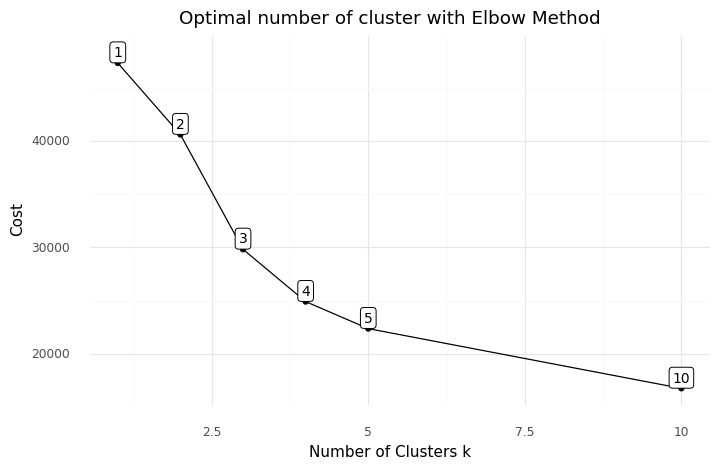

<ggplot: (8758465152725)>

In [25]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

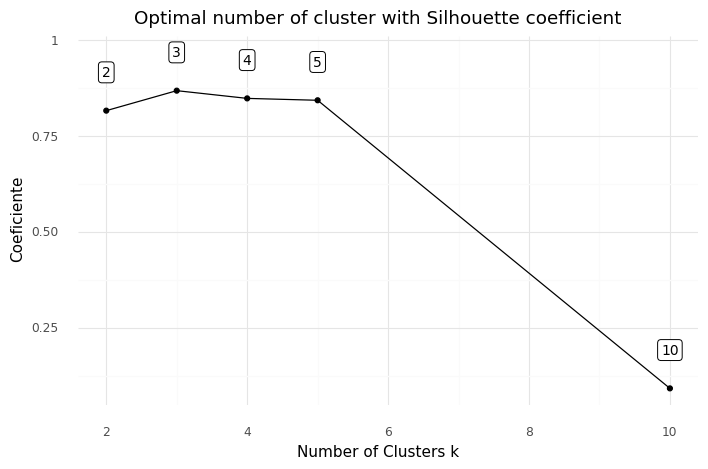

<ggplot: (8758465340053)>

In [26]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)

In [34]:
# Fit the cluster 
# k = 3
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', gamma = 0.5, random_state = 0)
kprototype.fit_predict(data3, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 168.28520226478577 seconds ---


In [35]:
print(kprototype.cluster_centroids_)

[['0.11422237814963888' '-0.015902280790626895' '1.0' '2' 'CAT17-C']
 ['1.7048385391605676' '34.568548384858424' '1.0' '2' 'CAT8-A']
 ['-3.5519420455990436' '-0.11971288241402163' '0.0' '37' 'CAT14-A']]


In [36]:
data3['Cluster Labels'] = kprototype.labels_

In [37]:
contingency = pd.crosstab(data3['Cluster Labels'], data3['CAT']) 
contingency

CAT,CAT1-A,CAT1-B,CAT1-C,CAT10-A,CAT10-B,CAT10-C,CAT11-C,CAT12-A,CAT12-B,CAT12-C,CAT14-A,CAT14-B,CAT14-C,CAT15-A,CAT15-B,CAT15-C,CAT16-A,CAT16-B,CAT16-C,CAT17-A,CAT17-B,CAT17-C,CAT2-A,CAT2-B,CAT2-C,CAT3-A,CAT3-B,CAT3-C,CAT4-A,CAT4-B,CAT4-C,CAT5-A,CAT5-B,CAT5-C,CAT6-A,CAT6-B,CAT6-C,CAT7-A,CAT7-B,CAT7-C,CAT8-A,CAT8-B,CAT8-C,CAT9-A,CAT9-B,CAT9-C
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,57,47,36,61,35,149,1,1594,361,494,1323,219,413,27,4,51,1079,644,687,1053,1301,1595,3,21,164,240,69,192,43,27,27,100,43,45,1,4,2,212,204,777,873,395,892,21,24,115
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0
2,3,2,1,4,0,2,0,75,15,18,177,4,3,0,1,0,27,4,12,12,10,16,1,1,0,13,0,5,7,0,0,11,1,0,0,0,0,16,6,6,37,13,7,0,0,0


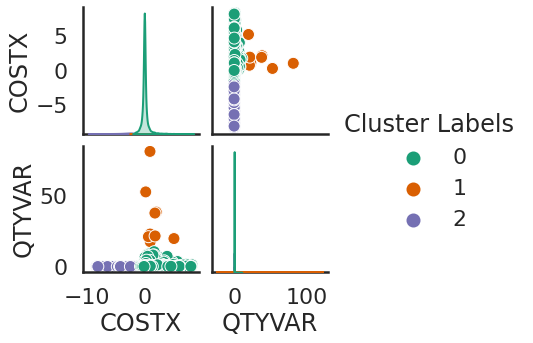

In [38]:
sns.pairplot(data3,hue='Cluster Labels',palette='Dark2',diag_kind='kde')

In [39]:
data3[data3['Cluster Labels']==2].describe()

,COSTX,QTYVAR,Cluster Labels
count,510.000000,510.000000,510.0
mean,-3.551942,-0.119713,2.0
std,1.656995,0.031206,0.0
min,-8.415911,-0.143812,2.0
25%,-4.453299,-0.143812,2.0
50%,-3.040966,-0.143812,2.0
75%,-2.256321,-0.090363,2.0
max,-1.620567,-0.033191,2.0
